# Neural Style Transfer

In [1]:
%matplotlib inline
import importlib
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model
import keras.backend as K
from keras import metrics
from keras.layers import AveragePooling2D
from glob import glob
from PIL import Image
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
path = './data/'

In [3]:
fnames = glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

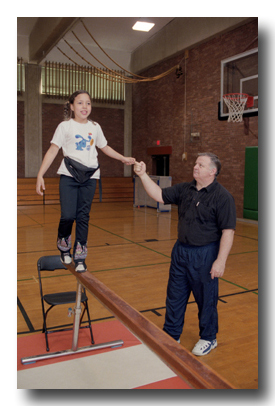

In [4]:
img = Image.open(fnames[70]); img

In [5]:
# rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
# preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [6]:
# deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
# img_arr = preproc(np.expand_dims(np.array(img), 0)); img_arr.shape

In [8]:
# deproc(img_arr.copy(), img_arr.shape)[0].shape

In [9]:
p = np.expand_dims(np.array(img), 0)
p_shape = p.shape; p_shape

(1, 406, 275, 3)

In [10]:
p[0].shape

(406, 275, 3)

## A Neural Algorithm of Artistic Style
* [paper](https://arxiv.org/abs/1508.06576)

### Approach
1. Content Representation
2. Style Representation

## 1. Content Representation
Recreate an image from noise based on the 'content loss' – the amount of difference between activations in some layer.

1. Pass an image(***p***) through model (VGG16). 
2. Pass a 'noise image' (***x***) through the same model.
3. At some layer ***l***, compare the outputs for both images using MSE.
4. We can change x until it generates the same response in layer l as p

In [11]:
model = vgg16.VGG16(include_top=False)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

MaxPooling is useful for image classification. It's not useful in this case, since MaxPooling loses information about the original input area. Instead we'll use AveragePooling, as this doesn't throw away as much information.

In [13]:
# grab activations near the end of conv model
layer = model.get_layer('block5_conv1').output

In [14]:
# calculate target activations for this layer
layer_model = Model(model.input, layer)
target = K.variable(layer_model.predict(p))

We need to be able to access the loss function and gradients separately, since that is what scikit-learn's optimizers require.

In [15]:
class Evaluator(object):
    def __init__(self, fn, shape): self.fn, self.shape = fn, shape
    
    def loss(self, x):
        loss_, self.grad_values = self.fn([x.reshape(self.shape)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [16]:
loss = metrics.mse(layer, target)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, p_shape)

Optimize loss function with a deterministic approach - line search.

In [17]:
def solve_image(evaluator, n_iterations, x):
    print(x.shape)
    for i in range(n_iterations):
        print('flatten', x.flatten().shape)
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        
        x = np.clip(x, -127, 127)
        print('Current loss value:', min_val)
        print('shape', x.shape)
        imsave(f'./results/res_at_iteration_{i}.png',x.reshape(p_shape)[0])
    return x

Generate random image

In [18]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(p_shape)

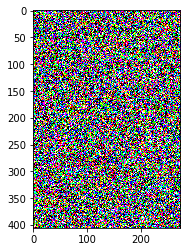

In [19]:
plt.imshow(x[0])

Run optimization

In [20]:
iterations=20

In [21]:
x = solve_image(evaluator, iterations, x)

(1, 406, 275, 3)
flatten (334950,)
Current loss value: [[[ 7497.58203125  5901.72900391  4008.01611328  2270.18994141
    2211.87597656  2259.65234375  2244.15332031  2355.15185547
    2713.27832031  2763.71704102  2037.63208008  1991.62487793
    2149.6328125   2424.6262207   3578.71240234  3920.83984375
    5816.2421875 ]
  [ 7227.34179688  7459.74365234  6213.25097656  3119.73168945
    2535.39208984  2452.60717773  2389.91308594  2467.1496582
    3429.42602539  3418.6171875   2361.296875    2198.96337891
    2764.57128906  3265.43261719  4837.55761719  5712.21972656
    5203.95117188]
  [ 6739.62695312  4808.24121094  4949.83984375  3369.99780273  2430.40625
    2407.38012695  2387.37353516  2865.1640625   3538.35571289
    2959.42041016  2153.64819336  1791.50317383  2131.81787109
    2664.16381836  4576.05175781  4017.63818359  3503.77783203]
  [ 5409.28417969  2602.57006836  2487.23730469  2157.70092773
    2456.95751953  2162.98852539  2197.99633789  2514.55053711
    2493.2707

Current loss value: [[[ 3952.19287109  2565.82592773  1835.27185059  1386.31091309
    1178.75585938  1180.93688965  1292.66687012  1221.96801758
    1211.92480469  1097.9276123   1017.5592041   1133.85876465
    1230.72387695  1305.68554688  1411.50866699  1422.5690918
    2909.60009766]
  [ 2965.47900391  2640.50463867  1865.7935791   1172.69042969
    1084.00366211  1127.59899902  1122.47253418  1117.16174316
    1176.12634277   978.86724854   893.2175293    869.45458984
    1078.72009277  1179.28076172  1761.94836426  2116.18652344
    2162.14282227]
  [ 2706.58203125  1518.90209961  1702.02648926  1256.61083984
    1101.93530273  1053.50878906   869.54516602  1185.28015137
    1055.2902832   1101.96044922   832.49804688   834.60809326
     928.21813965  1017.96893311  1547.2857666   1310.1706543   1387.953125  ]
  [ 2519.00341797  1116.3560791    878.20996094   911.80212402
     815.4041748    798.3614502    733.23419189   585.98474121
     661.45477295   751.66064453   482.587677

Current loss value: [[[ 2800.27636719  1514.05078125  1137.74133301   998.89959717
     738.52606201   751.35314941   865.44189453   767.6439209    753.2512207
     801.15887451   760.87316895   891.17144775  1042.90698242
    1036.08728027   955.00097656   895.41705322  2113.05078125]
  [ 1882.06176758  1405.15539551   794.82641602   629.02215576
     581.07635498   663.16674805   752.67144775   700.31713867
     712.71990967   573.34313965   594.3260498    619.32348633
     776.78430176   856.4934082   1140.06054688  1188.08776855
    1425.92114258]
  [ 1546.0847168    828.98944092   979.84588623   781.72692871
     596.27441406   696.33587646   454.82070923   688.63623047
     590.06610107   631.78656006   487.14797974   547.49066162
     628.48474121   665.53143311   981.99176025   869.34619141
     949.33630371]
  [ 1580.86230469   712.78308105   667.76831055   559.19421387
     513.89337158   469.70233154   410.37368774   302.99731445
     315.76043701   389.29953003   273.826354

Current loss value: [[[ 2419.56860352  1255.79187012   960.54772949   788.62524414
     588.48718262   573.80334473   639.59912109   591.51574707
     620.62390137   649.98803711   638.67889404   780.68377686
     920.4776001    875.30249023   698.27984619   642.19970703
    1653.40209961]
  [ 1551.93615723  1106.75061035   701.33374023   493.52496338
     471.2142334    474.61224365   473.27987671   447.74157715
     455.6819458    425.80545044   450.04034424   511.82250977
     690.86883545   719.6307373    724.74682617   780.88787842
    1065.0838623 ]
  [ 1238.18029785   611.73345947   775.49682617   649.12182617
     447.2338562    495.41381836   371.47763062   475.48620605
     460.60180664   465.21600342   349.48013306   429.23132324
     491.71307373   506.98461914   703.02124023   612.65814209
     652.83007812]
  [ 1151.00537109   492.18209839   473.77694702   405.69903564
     334.04580688   333.19155884   286.26638794   233.13313293
     237.13891602   292.51675415   216.44

Current loss value: [[[ 2194.82641602  1143.80883789   849.19256592   659.81634521
     520.09063721   489.18920898   512.05456543   498.59768677   562.043396
     577.11999512   579.00622559   688.68225098   819.75952148
     787.1027832    580.73138428   480.82348633  1371.49291992]
  [ 1353.84533691   976.51123047   604.64654541   412.81665039
     383.85980225   381.20681763   346.65234375   356.50073242
     380.56835938   356.36688232   411.95947266   435.19134521
     580.14764404   627.28393555   568.94720459   605.50964355
     840.03430176]
  [ 1063.08178711   549.88787842   691.76361084   576.23706055
     360.40390015   358.91607666   287.23364258   388.79684448
     341.88049316   340.88983154   288.80270386   318.41003418
     398.61181641   422.56161499   573.46209717   466.85314941
     560.51306152]
  [  922.72747803   367.9296875    362.09088135   336.90289307
     259.27990723   261.87072754   226.06988525   188.89837646
     188.73959351   255.87870789   195.2518463

Current loss value: [[[ 2031.00634766  1094.19262695   767.82769775   601.54046631
     496.81991577   443.85522461   460.67459106   457.32730103
     518.34155273   520.4732666    519.76208496   611.81793213
     760.50811768   740.14569092   540.77209473   455.9130249
    1241.46655273]
  [ 1237.30615234   951.17840576   571.23626709   363.39639282
     326.99945068   336.42834473   299.21139526   316.45050049
     351.47567749   337.1602478    364.23373413   400.66046143
     532.23828125   589.01470947   484.48397827   521.93103027
     731.87109375]
  [ 1026.86035156   535.06396484   648.78826904   508.20651245
     323.6401062    312.73394775   257.14654541   348.14880371
     300.1796875    294.4201355    246.7504425    271.84518433
     348.99459839   376.1005249    472.45858765   408.03408813
     481.2456665 ]
  [  845.16271973   328.33016968   309.68688965   328.88818359
     229.95358276   224.90185547   197.83468628   167.68495178
     167.79176331   232.71685791   188.682

Current loss value: [[[ 1889.60266113  1029.30786133   703.77416992   545.65979004
     459.26004028   391.30847168   420.76434326   442.92504883
     495.06958008   494.30307007   488.2428894    569.31414795
     704.49243164   681.10949707   494.62426758   415.77682495
    1153.59265137]
  [ 1156.47924805   883.97399902   513.31274414   331.31845093
     275.29953003   289.75091553   264.39056396   299.09072876
     333.44012451   302.00558472   310.46282959   361.22305298
     496.63482666   540.23468018   429.09869385   481.80114746
     654.7376709 ]
  [  935.4942627    490.96118164   584.83294678   445.16964722
     293.87042236   268.79562378   227.65879822   312.89398193
     268.65539551   255.44775391   216.56756592   243.09831238
     295.53546143   328.11593628   422.97979736   372.9513855
     425.72698975]
  [  772.54309082   306.89846802   278.92202759   293.95956421
     212.63595581   199.30348206   174.64103699   146.55387878
     150.02790833   214.16345215   164.807

Current loss value: [[[ 1962.10327148  1028.62988281   706.31402588   544.17578125
     460.20443726   391.71310425   423.39916992   447.31240845
     499.14181519   506.13446045   486.68963623   565.38677979
     688.84655762   677.20751953   495.90222168   417.87298584
    1163.52539062]
  [ 1189.74023438   915.86352539   531.19110107   335.25967407
     270.44442749   288.02709961   263.88354492   302.02410889
     330.38806152   305.97747803   311.01242065   360.36538696
     481.43652344   524.8616333    433.90264893   502.26956177
     661.22930908]
  [  935.27069092   459.80706787   558.86248779   431.12997437
     286.65863037   264.46920776   218.27375793   316.36239624
     265.66384888   258.33465576   210.51873779   239.89778137
     287.66873169   330.67922974   415.4836731    370.8381958
     421.70153809]
  [  780.87298584   307.62542725   269.63772583   282.16607666
     208.13192749   193.10673523   171.52326965   149.17010498
     158.25750732   212.13059998   166.576

Current loss value: [[[ 1962.49169922  1022.77124023   703.23724365   543.79870605
     460.00292969   391.52249146   423.24517822   446.58114624
     497.81842041   504.5513916    486.38549805   564.98120117
     688.75567627   676.50494385   495.10516357   417.81149292
    1163.42089844]
  [ 1184.09057617   905.90795898   527.88201904   334.53341675
     270.13427734   287.9927063    263.96551514   301.72979736
     330.49667358   304.60568237   310.03659058   360.52310181
     481.06512451   524.18505859   432.38909912   499.05389404
     659.87139893]
  [  932.62884521   461.25717163   559.83868408   428.48431396
     286.58453369   264.4473877    218.15200806   314.50866699
     265.21612549   258.4465332    210.2796936    239.9899292
     287.76809692   330.28881836   416.03665161   369.72659302
     421.19924927]
  [  778.42059326   306.0958252    268.927948     283.39031982
     207.84674072   193.24241638   171.05679321   148.76319885
     157.69573975   211.69631958   166.154

Current loss value: [[[ 1962.49328613  1022.73345947   703.21691895   543.79632568
     460.00189209   391.52133179   423.24359131   446.57611084
     497.80917358   504.54064941   486.3838501    564.97894287
     688.75500488   676.50048828   495.10018921   417.81167603
    1163.41882324]
  [ 1184.05114746   905.84295654   527.86169434   334.52981567
     270.1322937    287.99230957   263.96560669   301.72894287
     330.49798584   304.59674072   310.03036499   360.52416992
     481.06265259   524.18023682   432.37832642   499.03491211
     659.86474609]
  [  932.61035156   461.26895142   559.84851074   428.46755981
     286.58450317   264.44665527   218.15090942   314.49636841
     265.21383667   258.44735718   210.27890015   239.99163818
     287.76882935   330.28665161   416.04049683   369.71975708
     421.19622803]
  [  778.40313721   306.08526611   268.92532349   283.39849854
     207.84495544   193.2436676    171.05329895   148.76091003
     157.69255066   211.69419861   166.15

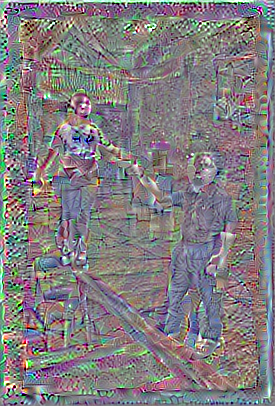

In [22]:
Image.open('./results/res_at_iteration_19.png')

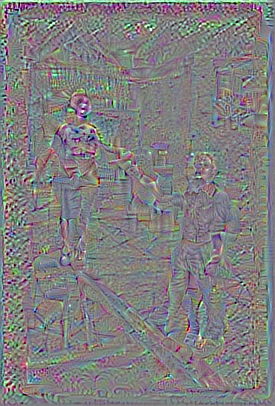

In [23]:
Image.open('./results/res_at_iteration_1.png')